# Emotion recognition group 16
### Members
- Rens Scheepers: 1622749
- Zijian Dong: 2268264
- Timo Vojnic Zelic: 172411

Python version: 3.13.5  

packages used:
asttokens==3.0.0
colorama==0.4.6
comm==0.2.3
contourpy==1.3.3
cycler==0.12.1
debugpy==1.8.17
decorator==5.2.1
executing==2.2.1
fonttools==4.60.1
fst-pso==1.9.0
git-filter-repo==2.47.0
imageio==2.37.0
ipykernel==7.0.1
ipython==9.6.0
ipython_pygments_lexers==1.1.1
jedi==0.19.2
joblib==1.5.2
jupyter_client==8.6.3
jupyter_core==5.9.0
kiwisolver==1.4.9
lazy_loader==0.4
matplotlib==3.10.7
matplotlib-inline==0.1.7
miniful==0.0.6
nest-asyncio==1.6.0
networkx==3.5
numpy==2.3.4
packaging==25.0
pandas==2.3.3
parso==0.8.5
pillow==12.0.0
platformdirs==4.5.0
prompt_toolkit==3.0.52
psutil==7.1.0
pure_eval==0.2.3
pyFUME==0.3.1
Pygments==2.19.2
pyparsing==3.2.5
python-dateutil==2.9.0.post0
pytz==2025.2
pyzmq==27.1.0
scikit-image==0.25.2
scikit-learn==1.7.2
scipy==1.16.2
seaborn==0.13.2
simpful==2.12.0
six==1.17.0
stack-data==0.6.3
threadpoolctl==3.6.0
tifffile==2025.10.4
tornado==6.5.2
traitlets==5.14.3
typing_extensions==4.15.0
tzdata==2025.2

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from joblib import dump, load # for pickle saving and loading
import os

# data preperation
from sklearn.utils.class_weight import compute_class_weight
from skimage.transform import AffineTransform, warp, rotate

# feature extraction
from skimage.feature import hog, local_binary_pattern
from skimage.filters import gabor as sk_gabor
from skimage.measure import moments_hu
from scipy.fft import dctn
from scipy.signal import convolve2d

# feature selection
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components

# build representation
from sklearn.decomposition import PCA  

# machine learning models
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from pyfume.pyfume import pyFUME 
from sklearn.base import BaseEstimator, ClassifierMixin

from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report, confusion_matrix, cohen_kappa_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV


EMOTION_CLASSES = {
    0:'0: Angry',
    1:'1: Disgust',
    2:'2: Fear',
    3:'3: Happy',
    4:'4: Sad',
    5:'5: Surprise',
    6:'6: Neutral'
}


In [40]:
# load the data into dataframes
train_data = pd.read_csv("data/fer2013_train.csv") 
validation_data = pd.read_csv("data/fer2013_validation.csv") 
test_data = pd.read_csv("data/fer2013_test.csv") 

Starting distribution of data per class:
0: Angry: 3995
1: Disgust: 436
2: Fear: 4097
3: Happy: 7215
4: Sad: 4830
5: Surprise: 3171
6: Neutral: 4965


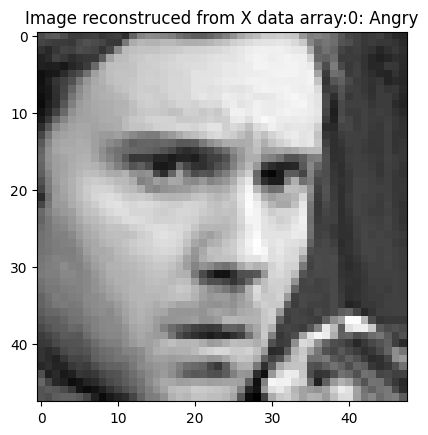

Class 0: +3221 augmented added
Class 1: +6780 augmented added
Class 2: +3119 augmented added
Class 3: +1 augmented added
Class 4: +2386 augmented added
Class 5: +4045 augmented added
Class 6: +2251 augmented added
Distribution of data per class after augmentation:
0: Angry: 7216
1: Disgust: 7216
2: Fear: 7216
3: Happy: 7216
4: Sad: 7216
5: Surprise: 7216
6: Neutral: 7216


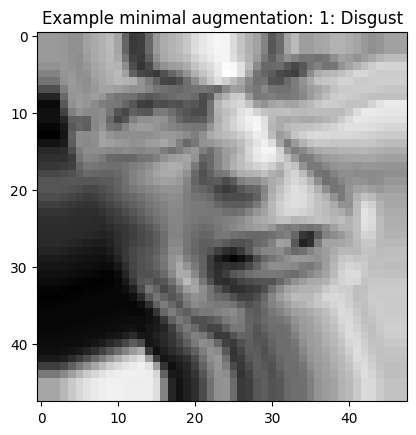

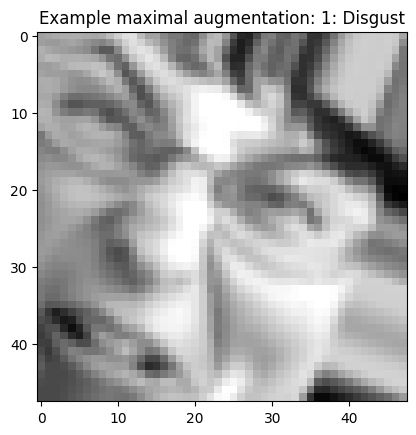

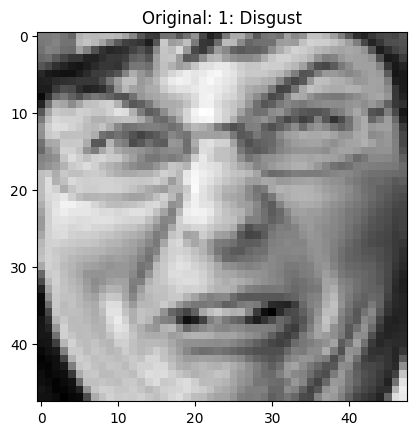

In [41]:
class DataPreperation:
    """
    Augment only the under-represented classes with label preserving transformations.
    Augmentation should reduce variance and improve invariance.
    Invariants:
    - translation 
    - rotation 
    - scaling 
    - lighting 
    - horizontal flip (because faces are horizontally symmetric, they are not vertically symmetric)

    Give class weights to use in training. they correct residual imbalance seen by the loss. 
    It should not have to be used, as augmentation already balances the dataset

    output:
    - self.X_data_augmented
    - self.Y_data_augmented 
    """
    def __init__(self):
        self.rng = np.random.default_rng(1712411)

        # the uniformly sampled probability that determines whether an operation is done when augmenting
        self.augment_probabilities = {
            "translation": 0.8,
            "rotate": 0.6,
            "scaling": 0.5,
            "lighting": 0.7,
            "horizontal-flip": 1.0 # always at least flip the image to avoid duplicates
        }

        # The range in which a uniformly sample value determines the augmentation
        self.augment_range = {
            "translation": (-6,6), # pixels
            "rotate": (-20,20), # degrees
            "scaling": (0.9, 1.1), # factor
            "lighting": (0.75, 1.25) # factor
        }

    # invariant augmentations (use scikit-image):
    def translation(self, X_data:np.ndarray, pixels: tuple[int, int]) -> np.ndarray:
        """ Translate by an amount of pixels (x,y) (stay between 2 and 6)."""
        tx, ty = pixels # amount of pixels to translate in x and y

        augmented_data = np.empty_like(X_data, dtype=np.float32) # initiate empty array for augmented images
        for index, image in enumerate(X_data):
            # translation is affine transform
            tform = AffineTransform(translation=(tx, ty))
            augmented = warp(image, tform.inverse, mode='edge', preserve_range=True)
            # stay within normalized range
            augmented_data[index] = np.clip(augmented, 0.0, 1.0).astype(np.float32)

        return augmented_data
    
    def rotation(self, X_data:np.ndarray, degrees: float) -> np.ndarray:
        """ Give the image pixels a rotation around the center (stay between -20, 20 degrees)."""
        
        augmented_data = np.empty_like(X_data, dtype=np.float32) # initiate empty array for augmented images
        for index, image in enumerate(X_data):
            augmented = rotate(image, angle=degrees, resize=False, mode='edge', preserve_range=True)
            # stay within normalized range
            augmented_data[index] = np.clip(augmented, 0.0, 1.0).astype(np.float32)

        return augmented_data

    def scaling(self, X_data:np.ndarray, factor: float) -> np.ndarray:
        """ Scale the image pixels (stay between 0.8 and 1.2 %)"""
        # center image
        height, width = X_data.shape[1], X_data.shape[2]
        cx, cy = width / 2.0, height / 2.0

        augmented_data = np.empty_like(X_data, dtype=np.float32) # initiate empty array for augmented images
        for index, image in enumerate(X_data):
            t1 = AffineTransform(translation=(-cx, -cy)) # translate to origin
            s  = AffineTransform(scale=(factor, factor)) # scale by factor
            t2 = AffineTransform(translation=(cx, cy)) # translate back 
            tform = t1 + s + t2
            augmented = warp(image, tform.inverse, mode='edge', preserve_range=True)
            # stay within normalized range
            augmented_data[index] = np.clip(augmented, 0.0, 1.0).astype(np.float32)

        return  augmented_data
    
    def lighting(self, X_data:np.ndarray, light_intensity: float) -> np.ndarray:
        """ Change the lighting of all pixels (stay between 0.8 and 1.2)."""
        out = (X_data.astype(np.float32) * light_intensity) # change lighting intensity by multiplying with factor
        return np.clip(out, 0.0, 1.0).astype(np.float32) # stay within normalized range

    def horizontal_flip(self, X_data:np.ndarray) -> np.ndarray:
        """ flip over the y axis """
        return np.flip(X_data,axis=2)
    
    # building up X and Y for feature extraction:
    def x_y_split(self, data: pd.DataFrame, verbose: bool = False) -> tuple[np.ndarray, np.ndarray]:
        """Turn the dataframe into X and Y arrays
        optionally print the distribution per class to good a sense of class representation in the data. """
        self.verbose = verbose
        # turn dataframe into numpy array with grayscale values
        X_data = np.array([np.fromstring(pixels, sep=' ') for pixels in data['pixels']]) 
        # normalize X_data [0,255] to [0,1]
        X_data = X_data.astype(np.float32)  / 255.0
        # get X data into 48x48 image pixel grid 
        X_data = X_data.reshape(-1, 48, 48)
        
        # get numeric class labels into numpy array
        Y_data = np.array(data['emotion'].values)
        if self.verbose:
            # count how many items are in the data set for each class 
            unique, counts = np.unique(Y_data, return_counts=True)
            print("Starting distribution of data per class:")
            for label, count in zip(unique, counts):
                print(f"{EMOTION_CLASSES[label]}: {count}")

            plt.imshow(X_data[0], cmap='gray')
            plt.title(f"Image reconstruced from X data array:{EMOTION_CLASSES[Y_data[0]]}")
            plt.show()
        
        return X_data, Y_data
    
    def x_y_split_augmented(self, data: pd.DataFrame, verbose: bool = False):
        """ Combine the invariant operations to balance out under under represented classes.
        Randomly perform augmentations, the probabilities can be changed in class configuration."""
        self.verbose = verbose
        X_data, Y_data = self.x_y_split(data, verbose)
        
        classes, counts = np.unique(Y_data, return_counts=True)
        target_image_n = counts.max() # aim for every class to have the same amount of images as the largest class has

        # make lists to append
        X_out = [X_data]
        Y_out = [Y_data]

        for c, n in zip(classes, counts): # iterate over classes and amount of images they have
            images_needed = target_image_n - n + 1 # make at least one augment image for the class with the most images
            
            class_indexes = np.where(Y_data==c)[0] # select the images of the current class
            augmented_images = []

            for _ in range(images_needed):
                index = int(self.rng.choice(class_indexes)) # pick a random image to augment
                img = X_data[index][None, ...]  # shape (1,48,48) to use the X_data input

                # apply augmentations based on probabilities
                if self.rng.random() < self.augment_probabilities["translation"]:
                    # apply translation if random number is below threshold probability
                    lo, hi = self.augment_range["translation"]   # (0.8, 1.2)
                    tx = int(self.rng.uniform(lo, hi))
                    ty = int(self.rng.uniform(lo, hi))
                    img = self.translation(img, (tx, ty)) 
                
                if self.rng.random() < self.augment_probabilities["rotate"]:
                    lo, hi = self.augment_range["rotate"]    
                    degree = float(self.rng.uniform(lo, hi))
                    img = self.rotation(img, degree) 

                if self.rng.random() < self.augment_probabilities["scaling"]:
                    lo, hi = self.augment_range["scaling"]   
                    factor = float(self.rng.uniform(lo, hi))
                    img = self.scaling(img, factor) 

                if self.rng.random() < self.augment_probabilities["lighting"]:
                    lo, hi = self.augment_range["lighting"]  
                    light_intensity = float(self.rng.uniform(lo, hi))
                    img = self.lighting(img, light_intensity) 

                if self.rng.random() < self.augment_probabilities["horizontal-flip"]:
                    img = self.horizontal_flip(img)
                
                augmented_images.append(img[0]) # add to list

            # save images in X,Y format
            aug_imgs = np.stack(augmented_images, axis=0).astype(np.float32)
            aug_labels = np.full(images_needed, c, dtype=Y_data.dtype)

            X_out.append(aug_imgs)
            Y_out.append(aug_labels)
            
            # print how many images where added with augmentation
            if self.verbose:
                print(f"Class {c}: +{images_needed} augmented added")
        
        X_data_augmented = np.concatenate(X_out, axis=0).astype(np.float32)
        Y_data_augmented = np.concatenate(Y_out, axis=0)

        # summary of resulting distributions per class
        if self.verbose:
            unique, counts = np.unique(Y_data_augmented, return_counts=True)
            print("Distribution of data per class after augmentation:")
            for label, count in zip(unique, counts):
                print(f"{EMOTION_CLASSES[label]}: {count}")
        
        # show what augmentation is doing
        if self.verbose:
            class_select = 1 # 1 = disgust
            class_indexes = np.where(Y_data==class_select)[0]
            img = X_data[class_indexes[0]][None, ...] # get the first image for disgust

            min_params = {
                "translate": (self.augment_range["translation"][0], self.augment_range["translation"][0]),
                "rotate": self.augment_range["rotate"][0],
                "scaling": self.augment_range["scaling"][0],
                "lighting": self.augment_range["lighting"][0]
            }

            max_params = {
                "translate": (self.augment_range["translation"][1], self.augment_range["translation"][1]),
                "rotate": self.augment_range["rotate"][1],
                "scaling": self.augment_range["scaling"][1],
                "lighting": self.augment_range["lighting"][1]
            }

            # apply all augmentations
            for label, params in [("minimal", min_params), ("maximal", max_params)]:
                img_aug = self.translation(img, params["translate"])
                img_aug = self.rotation(img_aug, params["rotate"])
                img_aug = self.scaling(img_aug, params["scaling"])
                img_aug = self.lighting(img_aug, params["lighting"])
                img_aug = self.horizontal_flip(img_aug)

                plt.imshow(img_aug[0], cmap="gray")  # show 2D
                plt.title(f"Example {label} augmentation: {EMOTION_CLASSES[class_select]}")
                plt.show()

            # Show original for reference
            plt.imshow(img[0], cmap="gray")
            plt.title(f"Original: {EMOTION_CLASSES[class_select]}")
            plt.show()
        
        return X_data_augmented, Y_data_augmented
    
    def class_weights(self, Y_data_augmented: np.ndarray):
        """ Use sklearns tool to get class weights based on the augmented Y data labels """
        classes = np.unique(Y_data_augmented)
        class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=Y_data_augmented)
        class_weight_dict = {c:w for c, w in zip(classes, class_weights)}
        print("Class weights for training")
        if self.verbose:
            for c, w in class_weight_dict:
                print(f"{EMOTION_CLASSES[c]}: {w}")
        return class_weight_dict

dataprep= DataPreperation()

X_train_augmented, Y_train_augmented = dataprep.x_y_split_augmented(train_data, verbose=True)
X_validation, Y_validation = dataprep.x_y_split(validation_data)
X_test, Y_test = dataprep.x_y_split(test_data)

### Feature Extraction
The features that are used are:
- HOG (historgram of oriented gradients)
    - Encodes local edge direction and contrast: gives edges and contours of facial features.
    - Uses small cells (like 8x8 pixels), kind of like a convolutional network.
- LBP (local binary pattern)
    - Compares the brightness of a pixel to its neighbours; this patterns forms a small binary number describing local texture.
    - It recognizes micro-textures like fabric, hair and skin.
- GLCM (gray level co-occurence matrix)
    - Captures how often gray levels occur next to each other at a specific distance and direction.
    - The resulting matrix allows for getting Haralick features like contrast, energy, homogenity and correlation
- DCT (discrete cosine transform)
    - Works with a frequency domain representation, low frequencies are smooth regions, high frequencies are fine detail.
    - kepping low frequency parts (low coefficients) gives a representation with reduced noise
    - gives global frequency components
    - how smooth is the image overall?
- wavelet transform
    - Wavelet decomposition gives scales like levels of zooming, at each level a sub images give details.
    - A summary of a sub image (mean, variance, energy), captures multi-scale texture and local frequency information.
    - gives both spatial and frequnecy localization
    - what details exist at what scales?
- hu moments
    - seven values computed from the geometric moments of an image, describing overall shape structure.
    - invariant to rotation, scale and translation; see if an image is round, elongated or symmetric.
- zernike moments
    - similar to hu moments bu computed using orthogonal polynomials


In [42]:
class Features:
    def __init__(self, X_data:np.ndarray):
        self.X = X_data # (48, 48, N)

        self._feature_names, self._features  = Features.available()
    
    def feature(fn):
        """ make a decorator for available functions"""
        fn._is_feature = True
        return fn
    
    @classmethod
    def available(cls):
        """ expose available methods to outside world"""
        fns = [
            getattr(cls, name)
            for name in dir(cls)
            if getattr(getattr(cls, name), "_is_feature", False)
        ] # this stores the executable methods that have the feature decorator
        names = tuple(fn.__name__ for fn in fns) # this only stores the names as strings
        return names, fns

    @feature
    def HOG(self, cell_pixels: int = 8, block: int = 2, nbins: int = 9) -> np.ndarray:
        """ Histogram of Oriented Gradients
        inputs:
        - cell_pixels: cell size in pixels (default 8 -> 8x8)
        - block: block size in cells (default 2 -> 2x2 cells)
        - nbins: #bins for unsigned orientation (0..180°), default 9
        output:
        - array (N, feat_len); for 48x48 with 8px cells and 2x2 blocks -> (N, 900)
        """
        H, W, N = self.X.shape
        feats = []
        for i in range(N):  # loop over images, hog itself is optimized
            img = self.X[:, :, i].astype(np.float32)
            f = hog(
                img,
                pixels_per_cell=(cell_pixels, cell_pixels),
                cells_per_block=(block, block),
                orientations=nbins,
                visualize=False,
                feature_vector=True
            )
            feats.append(f.astype(np.float32))
        return np.stack(feats, axis=0)

    @feature
    def LBP(self, P: int = 8, R: float = 1.0, method: str = "uniform", n_bins: int | None = None) -> np.ndarray:
        """ Local Binary Pattern (histogram)
        inputs:
        - P: #circular neighbors
        - R: radius
        - method: 'uniform'|'default'|'ror' etc. (skimage)
        - n_bins: histogram bins; if None and method='uniform' -> P+2
        output:
        - array (N, n_bins); for P=8 with 'uniform' -> (N, 10)
        """
        H, W, N = self.X.shape
        if n_bins is None and method == "uniform":
            n_bins = P + 2  # skimage convention for uniform
        feats = []
        for i in range(N):
            img = self.X[:, :, i].astype(np.float32)
            lbp = local_binary_pattern(img, P=P, R=R, method=method)
            hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
            feats.append(hist.astype(np.float32))
        return np.stack(feats, axis=0)

    def glcm_np(self, image: np.ndarray, levels: int = 32, distances=(1,), angles=(0, np.pi/4, np.pi/2, 3*np.pi/4),
                symmetric: bool = True, normed: bool = True) -> np.ndarray:
        """ build co-occurrence tensor P without skimage.greycomatrix
        inputs:
        - image: 2D grayscale; internally normalized + quantized to [0, levels-1]
        - levels: quantization levels
        - distances: offsets (pixels)
        - angles: directions (radians)
        output:
        - P with shape (levels, levels, len(distances), len(angles))
        """
        img = image.astype(np.float32)
        imn = img - img.min()
        imn = imn / (imn.max() + 1e-6)
        q = np.floor(imn * (levels - 1)).astype(np.int32)

        H, W = q.shape
        P = np.zeros((levels, levels, len(distances), len(angles)), dtype=np.float64)

        offsets = []
        for d in distances:
            for a in angles:
                dy = int(round(np.sin(a) * d))
                dx = int(round(np.cos(a) * d))
                offsets.append((dy, dx))

        k = 0
        for di, _d in enumerate(distances):
            for ai, _a in enumerate(angles):
                dy, dx = offsets[k]; k += 1

                if dy >= 0:
                    ys = slice(0, H - dy); yt = slice(dy, H)
                else:
                    ys = slice(-dy, H);     yt = slice(0, H + dy)
                if dx >= 0:
                    xs = slice(0, W - dx); xt = slice(dx, W)
                else:
                    xs = slice(-dx, W);     xt = slice(0, W + dx)

                src = q[ys, xs]
                tgt = q[yt, xt]

                flat = src * levels + tgt
                binc = np.bincount(flat.ravel(), minlength=levels * levels).astype(np.float64)
                M = binc.reshape(levels, levels)

                if symmetric:
                    M = M + M.T
                if normed:
                    s = M.sum()
                    if s > 0:
                        M = M / s

                P[:, :, di, ai] = M

        return P

    def glcm_props_np(self, P: np.ndarray, props=("contrast","dissimilarity","homogeneity","ASM","energy","correlation")) -> dict:
        """ compute standard GLCM properties from P (L,L,D,A)
        returns: dict prop -> array (D, A)
        """
        L, _, D, A = P.shape
        I = np.arange(L).reshape(L, 1, 1, 1)
        J = np.arange(L).reshape(1, L, 1, 1)

        mu_x = (I * P).sum(axis=(0, 1))
        mu_y = (J * P).sum(axis=(0, 1))
        sig_x = np.sqrt(((I - mu_x)**2 * P).sum(axis=(0, 1)) + 1e-12)
        sig_y = np.sqrt(((J - mu_y)**2 * P).sum(axis=(0, 1)) + 1e-12)

        diff = (I - J)
        absdiff = np.abs(diff)

        out = {}
        if "contrast" in props:
            out["contrast"] = ((diff**2) * P).sum(axis=(0, 1))
        if "dissimilarity" in props:
            out["dissimilarity"] = (absdiff * P).sum(axis=(0, 1))
        if "homogeneity" in props:
            out["homogeneity"] = (P / (1.0 + diff**2)).sum(axis=(0, 1))
        if "ASM" in props:
            asm = (P**2).sum(axis=(0, 1)); out["ASM"] = asm
            if "energy" in props:
                out["energy"] = np.sqrt(asm)
        elif "energy" in props:
            out["energy"] = np.sqrt((P**2).sum(axis=(0, 1)))
        if "correlation" in props:
            num = ((I - mu_x) * (J - mu_y) * P).sum(axis=(0, 1))
            den = (sig_x * sig_y)
            out["correlation"] = num / den

        return out

    @feature
    def GLCM(self) -> np.ndarray:
        """ Gray Level Co-occurrence Matrix (texture props)
        inputs:
        - levels: quantization levels (fixed 32 here)
        - distances: pixel offsets (fixed (1,))
        - angles: directions in rad (0, 45°, 90°, 135°)
        - props: contrast, dissimilarity, homogeneity, ASM, energy, correlation
        output:
        - array (N, 6*len(angles)) -> (N, 24) with defaults
        """
        levels = 32
        distances = (1,)
        angles = (0, np.pi/4, np.pi/2, 3*np.pi/4)
        props = ("contrast", "dissimilarity", "homogeneity", "ASM", "energy", "correlation")

        H, W, N = self.X.shape
        feats = []
        for i in range(N):
            P = self.glcm_np(self.X[:, :, i], levels=levels, distances=distances, angles=angles, symmetric=True, normed=True)
            d = self.glcm_props_np(P, props=props)
            v = np.concatenate([d[p].squeeze(axis=0) for p in props], axis=0)
            feats.append(v.astype(np.float32))
        return np.stack(feats, axis=0)

    @feature
    def DCT(self, k: int = 8) -> np.ndarray:
        """ 2D Discrete Cosine Transform (low-freq patch)
        inputs:
        - k: keep top-left k x k (low-frequency) block; default 8 -> 64 dims
        output:
        - array (N, k*k)
        """
        H, W, N = self.X.shape
        feats = []
        for i in range(N):
            img = self.X[:, :, i].astype(np.float32)
            F = dctn(img, type=2, norm="ortho")
            feats.append(F[:k, :k].ravel().astype(np.float32))
        return np.stack(feats, axis=0)

    def gabor(self, freqs: list[float] = [0.1], thetas: list[float] = [ np.pi/2]) -> np.ndarray:
        """ 
        ---- Do not use this features because it takes way to long to compute --------
        Gabor filter bank (magnitude stats)
        inputs:
        - freqs: cycles/pixel list
        - thetas: orientations in radians
        output:
        - array (N, 2 * len(freqs) * len(thetas))  [mean, std per filter]
        """
        H, W, N = self.X.shape
        feats = []
        for i in range(N):
            img = self.X[:, :, i].astype(np.float32)
            imn = img - img.min()
            imn = imn / (imn.max() + 1e-6)
            parts = []
            for f0 in freqs:
                for th in thetas:
                    real, imag = sk_gabor(imn, frequency=f0, theta=th)
                    mag = np.hypot(real, imag)
                    parts.append(np.mean(mag, dtype=np.float64))
                    parts.append(np.std(mag, dtype=np.float64))
            feats.append(np.array(parts, dtype=np.float32))
        return np.stack(feats, axis=0)

    def haar_dwt2_level(self, img: np.ndarray):
        """ 1-level 2D Haar DWT (LL, LH, HL, HH) with symmetric pad + decimate by 2 """
        invsqrt2 = 1.0 / np.sqrt(2.0)
        h = np.array([invsqrt2, invsqrt2], dtype=np.float32)
        g = np.array([invsqrt2, -invsqrt2], dtype=np.float32)

        Lr = convolve2d(img, h.reshape(1, -1), mode="same", boundary="symm")
        Hr = convolve2d(img, g.reshape(1, -1), mode="same", boundary="symm")

        LL = convolve2d(Lr, h.reshape(-1, 1), mode="same", boundary="symm")
        LH = convolve2d(Lr, g.reshape(-1, 1), mode="same", boundary="symm")
        HL = convolve2d(Hr, h.reshape(-1, 1), mode="same", boundary="symm")
        HH = convolve2d(Hr, g.reshape(-1, 1), mode="same", boundary="symm")

        return LL[::2, ::2], LH[::2, ::2], HL[::2, ::2], HH[::2, ::2]

    def wavelet_haar_energies(self, img: np.ndarray, levels: int = 2) -> np.ndarray:
        """ multilevel Haar energies: [E(LL_L), E(LH_L), E(HL_L), E(HH_L), ..., E(LH_1), E(HL_1), E(HH_1)]
        inputs:
        - img: 2D grayscale
        - levels: #DWT levels (default 2)
        output:
        - vector length 1 + 3*levels
        """
        x = img.astype(np.float32)
        x = (x - x.min()) / (x.max() - x.min() + 1e-6)

        LL = x
        detail_levels = []
        for _ in range(levels):
            LL, LH, HL, HH = self.haar_dwt2_level(LL)
            detail_levels.append((LH, HL, HH))

        parts = [np.sum(LL**2, dtype=np.float64)]
        for (LH, HL, HH) in detail_levels:
            parts.extend([
                np.sum(LH**2, dtype=np.float64),
                np.sum(HL**2, dtype=np.float64),
                np.sum(HH**2, dtype=np.float64),
            ])
        return np.array(parts, dtype=np.float32)

    @feature
    def wavelet_transform(self) -> np.ndarray:
        """ Haar wavelet energy features
        inputs:
        - levels: fixed 2 here; returns cA2 energy + detail energies L2 and L1
        output:
        - array (N, 7)  [LL2, LH2, HL2, HH2, LH1, HL1, HH1]
        """
        H, W, N = self.X.shape
        feats = []
        for i in range(N):
            feats.append(self.wavelet_haar_energies(self.X[:, :, i], levels=2))
        return np.stack(feats, axis=0)

    @feature
    def hu_moments(self) -> np.ndarray:
        """ Hu moments (7), grayscale normalized to [0,1]
        inputs:
        - none
        output:
        - array (N, 7)
        """
        H, W, N = self.X.shape
        feats = []
        for i in range(N):
            img = self.X[:, :, i].astype(np.float32)
            imn = img - img.min()
            imn = imn / (imn.max() + 1e-6)
            hu = moments_hu(imn)
            feats.append(hu.astype(np.float32))
        return np.stack(feats, axis=0)

    def _zernike_radial(self, n: int, m: int, rho: np.ndarray) -> np.ndarray:
        """ radial polynomial R_n^m(rho); n-m even, 0<=m<=n """
        R = np.zeros_like(rho, dtype=np.float64)
        m = abs(m)
        if (n - m) % 2 != 0:
            return R
        kmax = (n - m) // 2
        for k in range(kmax + 1):
            c = ((-1.0)**k *
                 scipy.special.factorial(n - k, exact=False) /
                 (scipy.special.factorial(k, exact=False) *
                  scipy.special.factorial((n + m)//2 - k, exact=False) *
                  scipy.special.factorial((n - m)//2 - k, exact=False)))
            R += c * np.power(rho, n - 2*k)
        return R

    def _zernike_moments(self, image: np.ndarray, degree: int = 8, use_magnitude: bool = True) -> np.ndarray:
        """ Zernike moments up to degree over unit disk (discrete sum)
        inputs:
        - image: 2D grayscale; normalized inside unit disk
        - degree: max n
        - use_magnitude: True -> |Z_nm|, else complex Z_nm
        output:
        - vector of length equal to valid (n,m) pairs (n-m even, m>=0)
        """
        img = image.astype(np.float64)
        H, W = img.shape
        cy, cx = (H - 1) / 2.0, (W - 1) / 2.0
        r0 = min(H, W) / 2.0 - 1.0

        yy, xx = np.mgrid[0:H, 0:W]
        x = (xx - cx) / r0
        y = (yy - cy) / r0
        rho = np.sqrt(x**2 + y**2)
        theta = np.arctan2(y, x)
        mask = rho <= 1.0

        imn = img - img.min()
        imn = imn / (imn.max() + 1e-12)
        f = np.zeros_like(imn)
        f[mask] = imn[mask]

        moments = []
        for n in range(degree + 1):
            for m in range(0, n + 1):
                if (n - m) % 2 != 0:
                    continue
                Rnm = self._zernike_radial(n, m, rho)
                Vnm = Rnm * np.exp(-1j * m * theta)
                Znm = (n + 1) / np.pi * np.sum(f * Vnm * mask.astype(np.float64))
                moments.append(np.abs(Znm) if use_magnitude else Znm)
        return np.array(moments, dtype=np.complex128 if not use_magnitude else np.float64)

    @feature
    def zernike_moments(self, degree: int = 8, use_magnitude: bool = True) -> np.ndarray:
        """ Zernike moments (magnitude by default) on unit disk
        inputs:
        - degree: max order n (even/odd both allowed; only n-m even pairs included)
        - use_magnitude: take |Z_nm| if True, else complex values
        output:
        - array (N, zcount) where zcount depends on degree
        """
        H, W, N = self.X.shape
        feats = []
        for i in range(N):
            feats.append(self._zernike_moments(self.X[:, :, i], degree=degree, use_magnitude=use_magnitude).astype(np.float32))
        return np.stack(feats, axis=0)

class FeatureExtraction:
    """ Same for training, validation and test data.""" 
    def __init__(self, selected_feature_params: dict):
        """
        input:
        - selected_feature_params: A dictionary containing the names of features and the corresponding features. empty params dict > default
        """
        self.selected_feature_params = selected_feature_params
    
    def _ensure_dir(self, path_feature_storage: str):
        """ make directory """
        d = path_feature_storage if path_feature_storage.endswith(os.sep) else path_feature_storage + os.sep
        os.makedirs(d, exist_ok=True)
        return d

    def _param_string(self, params: dict) -> str:
        """make a filename based on feature with parameters"""
        if not params:
            return "default"
        parts = []
        for k in sorted(params.keys()):
            v = params[k]
            if isinstance(v, (list, tuple, np.ndarray)):
                v_str = "-".join(str(x) for x in (v.tolist() if isinstance(v, np.ndarray) else v))
            elif v is None:
                v_str = "None"
            elif isinstance(v, float):
                # compact float for filenames
                v_str = f"{v:.6g}"
            else:
                v_str = str(v)
            parts.append(f"{k}_{v_str}")
        return "__".join(parts)
    
    def _shape_to_HWN(self, X_data: np.ndarray) -> np.ndarray:
        """Make sure data has shape (48, 48, N); makes input robust to (N,48,48) or (48,48,N)"""
        if X_data.shape[0] == 48 and X_data.shape[1] == 48:
            # assume (48,48,N)
            return X_data
        if X_data.shape[1] == 48 and X_data.shape[2] == 48:
            # (N,48,48) -> (48,48,N)
            return np.transpose(X_data, (1, 2, 0))
        raise ValueError(f"Unexpected X_data shape {X_data.shape}; expected (N,48,48) or (48,48,N)")

    def get_features(self, X_data: np.ndarray, path_feature_storage: str = "data/features/train/", verbose:bool = False):
        """
        input:
        - X_data: The X data with the shape (N,48,48) or (48,48,N) ; with N the number of data points
        - path_feature_storage: location to save features as .npy file once they have been made.
        output:
        = X_feature: The features with D dimensions shaped as (N,D)
        """
        X_data_shaped = self._shape_to_HWN(X_data)
        N = X_data_shaped.shape[2] # amount of samples
        path_feature_storage = self._ensure_dir(path_feature_storage)

        features = Features(X_data_shaped)

        parts = []
        for feature_name, params in self.selected_feature_params.items():
            # make filename: <feature>__<param_string>.npy
            param_tag = self._param_string(params)
            fname = f"{feature_name}__{param_tag}.npy"
            fpath = os.path.join(path_feature_storage, fname)

            if os.path.exists(fpath):
                if verbose:
                    print(f"[load] {feature_name} ({param_tag}) from {fpath}")
                feature_array = np.load(fpath, allow_pickle=False)
                # quick sanity check if the features were computed on the same size data
                if feature_array.shape[0] != N:
                    raise ValueError(f"Loaded features for {feature_name} have N={feature_array.shape[0]} but X_data has N={N}")
            else:
                if verbose:
                    print(f"[compute] {feature_name} ({param_tag})")
                fn = getattr(features, feature_name, None)
                if fn is None or not callable(fn):
                    raise ValueError(f"Unknown feature: {feature_name}")
                feature_array = fn(**params) if params else fn()
                # enforce (N, d)
                if feature_array.ndim == 1:
                    feature_array = feature_array[:, None]
                # save
                np.save(fpath, feature_array.astype(np.float32, copy=False))
                if verbose:
                    print(f"[saved] {feature_name} -> {fpath} shape={feature_array.shape}")

            parts.append(feature_array.astype(np.float32, copy=False))

        if not parts:
            return np.empty((N, 0), dtype=np.float32)

        X_feature = np.concatenate(parts, axis=1) # build the (N,D) from all (N,d_i) parts
        return X_feature

selected_features_params = {
    "HOG": {
        "cell_pixels": 8,
        "block": 2,
        "nbins": 9,
    },
    "LBP": {
        "P": 8,
        "R": 1.0,
        "method": "uniform",
        "n_bins": None,
    },
    "GLCM": {},  # no params in method signature
    "DCT": {
        "k": 8,
    },
    "wavelet_transform": {},  
    "hu_moments": {},         
    "zernike_moments": {
        "degree": 8,
        "use_magnitude": True,
    }, # takes very long
}
extract_features = FeatureExtraction(selected_features_params)
X_train_features = extract_features.get_features(X_train_augmented, "data/features/train/", verbose=True)
X_validation_features = extract_features.get_features(X_validation, "data/features/validation/")
X_test_features = extract_features.get_features(X_test, "data/features/test/")

[compute] HOG (block_2__cell_pixels_8__nbins_9)
[saved] HOG -> data/features/train/\HOG__block_2__cell_pixels_8__nbins_9.npy shape=(50512, 900)
[compute] LBP (P_8__R_1__method_uniform__n_bins_None)


c:\Users\timov\OneDrive - FABBS\INTERNAL\Current_Projects_i\data analysis for ML\code_da_ML\emotion_recognition\Lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


[saved] LBP -> data/features/train/\LBP__P_8__R_1__method_uniform__n_bins_None.npy shape=(50512, 10)
[compute] GLCM (default)
[saved] GLCM -> data/features/train/\GLCM__default.npy shape=(50512, 24)
[compute] DCT (k_8)
[saved] DCT -> data/features/train/\DCT__k_8.npy shape=(50512, 64)
[compute] wavelet_transform (default)
[saved] wavelet_transform -> data/features/train/\wavelet_transform__default.npy shape=(50512, 7)
[compute] hu_moments (default)
[saved] hu_moments -> data/features/train/\hu_moments__default.npy shape=(50512, 7)
[compute] zernike_moments (degree_8__use_magnitude_True)
[saved] zernike_moments -> data/features/train/\zernike_moments__degree_8__use_magnitude_True.npy shape=(50512, 25)


### Feature Selection 
The goal here is creating the latent representation from features.

Select features based on:
- above a variance threshold
- above the knee in fisher info
- for a correlating group, pick the one with the best mutual info

Start: D = 1037
After _low_variance: D = 1037


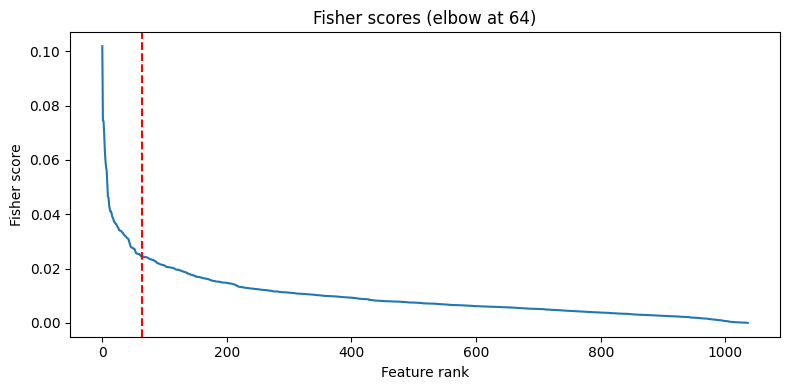

After _low_fisher_score: D = 64
After _corr_groups_by_mi: D = 42


In [43]:
# make it selectable which 
class DimensionSelection:
    """
    combine selected features into one (N,D) every individual feature dimension can be dropped.
    Have a 'fit_select' function for training data and a 'select' for validation and test data.
    """
    def __init__(self, selection_procedure: dict, scale: bool = True):
        self.selection_procedure = selection_procedure
        self.random_state = 1712411
        self.scale = scale
        
        # learned in training
        self.scaler: StandardScaler | None = None
        self._keep_idx: np.ndarray | None = None # which dimensions to keep after selection procedure

        self.verbose: bool = False # default off

    def _low_variance(self, X:np.ndarray, threshold: float = 1e-3) -> None:
        """ drop features that barely vary over samples
        This automatically drops duplicates and constant(0-info) features; they also get flagged by low variance. """
        vt = VarianceThreshold(threshold=threshold).fit(X)
        return vt.get_support(indices=True)  # indices in X
    
    def _low_fisher_score(self, X: np.ndarray, Y: np.ndarray, keep_minimum_d: int = 20) -> np.ndarray:
        """Drop features with Fisher score below the knee; 
        keep a minimum amount of dimensions incase the knee is very aggresive"""
        # Fisher per column
        mu = np.nanmean(X, axis=0)
        Sb = np.zeros(X.shape[1], dtype=np.float64)
        Sw = np.zeros(X.shape[1], dtype=np.float64)
        for c in np.unique(Y):
            m = (Y == c)
            if not np.any(m): 
                continue
            Xc = X[m]
            nc = Xc.shape[0]
            mu_c = np.nanmean(Xc, axis=0)
            var_c = np.nanvar(Xc, axis=0)
            Sb += nc * (mu_c - mu) ** 2
            Sw += nc * var_c
        fisher = np.nan_to_num(Sb / (Sw + 1e-12), nan=0.0, posinf=0.0, neginf=0.0)

        D = fisher.shape[0]
        if D <= 1:
            return np.arange(D)

        # elbow on sorted
        order = np.argsort(-fisher)
        y_sorted = fisher[order]
        x = np.arange(D, dtype=float)
        x0, y0 = 0.0, y_sorted[0]
        x1, y1 = float(D - 1), y_sorted[-1]
        denom = np.hypot(x1 - x0, y1 - y0) + 1e-12
        dist = np.abs((y1 - y0)*x - (x1 - x0)*y_sorted + x1*y0 - y1*x0) / denom
        k_elbow = int(np.argmax(dist)) + 1
        k = int(np.clip(k_elbow, keep_minimum_d, D))

        keep_sorted = np.zeros(D, bool); keep_sorted[:k] = True
        keep_mask = np.zeros(D, bool); keep_mask[order] = keep_sorted

        if keep_minimum_d > k_elbow and self.verbose:
            print(f"keeps the minimum: {keep_minimum_d}, the elbow is at {k_elbow}")

        if self.verbose:
            scores = np.sort(fisher)[::-1]
            plt.figure(figsize=(8,4))
            plt.plot(scores)
            plt.axvline(k_elbow, color='r', linestyle='--')
            plt.title(f"Fisher scores (elbow at {k_elbow})")
            plt.xlabel("Feature rank")
            plt.ylabel("Fisher score")
            plt.tight_layout()
            plt.show()

        return np.where(keep_mask)[0]
    
    def _corr_groups(self, X, threshold: float = 0.90) -> list[np.ndarray]:
        """ make groups of columns where |corr| >= threshold (connected components) """
        C = np.corrcoef(X, rowvar=False)
        C = np.nan_to_num(np.abs(C), nan=0.0, posinf=0.0, neginf=0.0)
        np.fill_diagonal(C, 0.0) # Ignore the perfect correlation on the diagonal
        adj = (C >= threshold).astype(np.uint8)
        g = csr_matrix(adj)
        n_comp, labels = connected_components(csgraph=g, directed=False, return_labels=True)
        return [np.where(labels == i)[0] for i in range(n_comp)]

    def _corr_groups_by_mi(self, X, Y, corr_threshold: float = 0.90) -> None:
        """ within each corr-group, keep only the column with highest MI (single in the group always kept) """
        groups = self._corr_groups(X, threshold=corr_threshold)
        Xsafe = np.nan_to_num(X, copy=False)  # handle inf/nan
        mi = mutual_info_classif(Xsafe, Y, discrete_features=False, random_state=1712411)

        keep = np.zeros(X.shape[1], dtype=bool)
        for g in groups:
            if g.size == 1:
                keep[g[0]] = True
            else:
                best = g[np.argmax(mi[g])]
                keep[best] = True

        return np.where(keep)[0]

    def fit_and_select(self,
                   X_train: np.ndarray,
                   Y_train: np.ndarray,
                   verbose: bool = False) -> np.ndarray:
        """ Progressively drop feature dimensions according to scores.
         For training only """
        self.verbose = verbose

        # scale if the keyword exists and its true; not if it does not exist or is set to False
        if self.scale: 
            self.scaler = StandardScaler().fit(X_train)
            X = self.scaler.transform(X_train)
        else:
            self.scaler = None
            X = X_train
            
        N, D_start = X.shape
        if self.verbose:
            print(f"Start: D = {D_start}")

        idx_keep = np.arange(D_start) # Track cumulative indices mapping back to original columns
        
        for method_name, params in self.selection_procedure.items():
            # get method if it exists
            if not hasattr(self, method_name):
                print(f"Warning: no method {method_name} found — skipped.")
                continue

            fn = getattr(self, method_name)

            # decide whether the function needs Y
            if "Y" in fn.__code__.co_varnames:
                idx_new = fn(X, Y_train, **params)
            else:
                idx_new = fn(X, **params)

            # update indices and X
            idx_keep = idx_keep[idx_new]
            X = X[:, idx_new]

            if self.verbose:
                print(f"After {method_name}: D = {X.shape[1]}")

        # somehow invert dropped_indexes and make it _keep_idx
        self._keep_idx = idx_keep
        
        return X

    def select(self, X: np.ndarray) -> np.ndarray:
        """Apply the already-fitted scaler and final column selection to validation and test data"""
        if self._keep_idx is None:
            raise RuntimeError("Call fit_and_select(...) on training data first.")

        if self.scaler is not None:
            Xs = self.scaler.transform(X)
        else:
            Xs = X

        return Xs[:, self._keep_idx]

selection_procedure = {
    "_low_variance": {"threshold": 1e-3},
    "_low_fisher_score": {"keep_minimum_d": 50},
    "_corr_groups_by_mi": {"corr_threshold": 0.90}
}

features_selector = DimensionSelection(selection_procedure)

X_train_selected = features_selector.fit_and_select(X_train_features, Y_train_augmented, verbose=True)
X_validation_selected = features_selector.select(X_validation_features)
X_test_selected = features_selector.select(X_test_features)

### Preperation for Machine learning models
The methods for making latent representations used here are:
- PCA: Projects data onto orthogonal axes maximizing variance

The Models, features and pipeline used are:
- SVM (support vector machine)
    - use HOG, LBP, DCT; gives edges and texture with good local-global seperation
    - use feature selection + PCA to get to approx 30 dimensions
    - SVM benefits from smooth numeric data
- MLP
    - use HOG, LBP, DCT, wavelet and hu moments; Use a wide variety of inputs
    - can learn nonlinear mixes and self-weights to ignore irrelevant feature dimensions
    - use feature selection + PCA keeping 99% of variance; for mild denoising
- Random forest
    - LBP, wavelet, hu_moments
    - use feature selection + PCA keeping 99% of variance to remove redundancy while keeping detail
- Fuzzy system 
    - Wavelet, Hu
    - suited for relativly low dimensions; so either use low dimensional features or implement dimensionality reduction
    - use feature selection + PCA keeping 5-15 dimensions



[load] HOG (block_2__cell_pixels_8__nbins_9) from data/features/train/\HOG__block_2__cell_pixels_8__nbins_9.npy
[load] LBP (P_8__R_1__method_uniform__n_bins_None) from data/features/train/\LBP__P_8__R_1__method_uniform__n_bins_None.npy
[load] DCT (k_8) from data/features/train/\DCT__k_8.npy
Start: D = 974
After _low_variance: D = 974


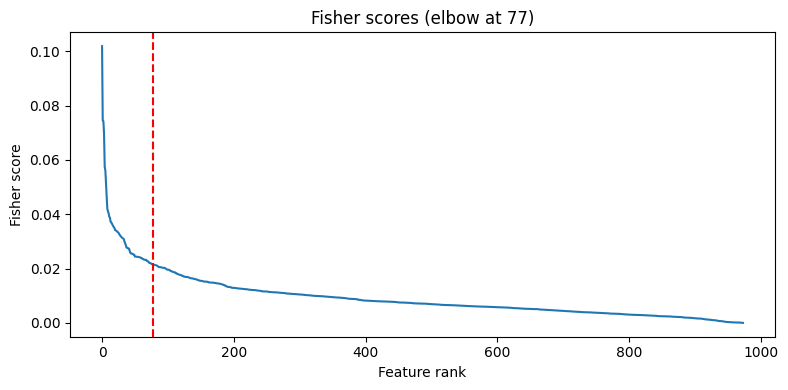

After _low_fisher_score: D = 77
After _corr_groups_by_mi: D = 46
Latent representation start: D = 46
After _PCA: D = 20
[load] HOG (block_2__cell_pixels_8__nbins_9) from data/features/train/\HOG__block_2__cell_pixels_8__nbins_9.npy
[load] LBP (P_8__R_1__method_uniform__n_bins_None) from data/features/train/\LBP__P_8__R_1__method_uniform__n_bins_None.npy
[load] DCT (k_8) from data/features/train/\DCT__k_8.npy
[load] wavelet_transform (default) from data/features/train/\wavelet_transform__default.npy
[load] hu_moments (default) from data/features/train/\hu_moments__default.npy
[load] zernike_moments (degree_8__use_magnitude_True) from data/features/train/\zernike_moments__degree_8__use_magnitude_True.npy
Start: D = 1013
After _low_variance: D = 1013


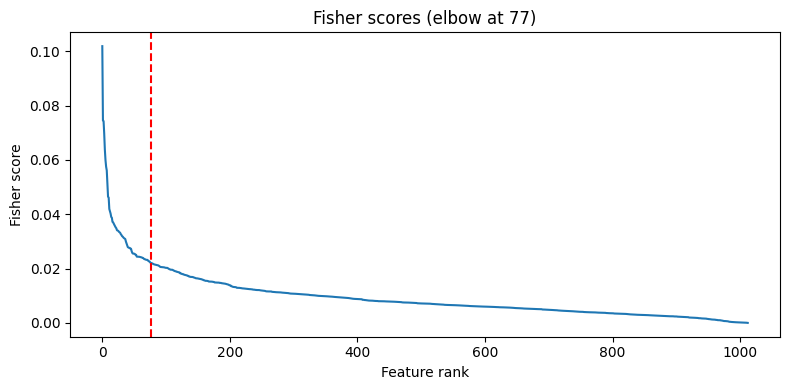

After _low_fisher_score: D = 77
After _corr_groups_by_mi: D = 45
Latent representation start: D = 45
After _PCA: D = 42
[load] LBP (P_8__R_1__method_uniform__n_bins_None) from data/features/train/\LBP__P_8__R_1__method_uniform__n_bins_None.npy
[load] wavelet_transform (default) from data/features/train/\wavelet_transform__default.npy
[load] hu_moments (default) from data/features/train/\hu_moments__default.npy
Start: D = 24
After _low_variance: D = 24
keeps the minimum: 40, the elbow is at 9


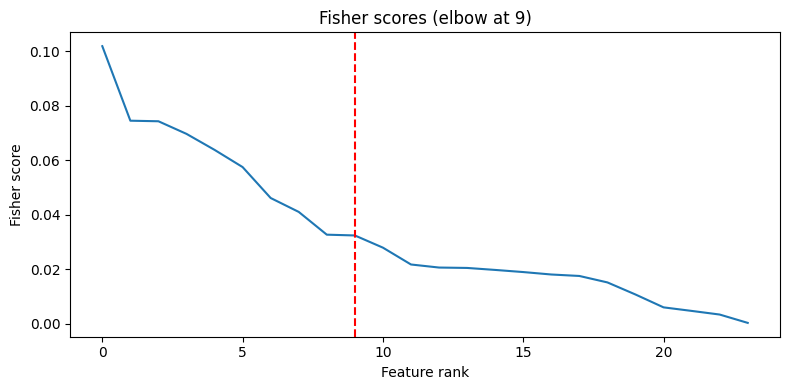

After _low_fisher_score: D = 24
After _corr_groups_by_mi: D = 19
Latent representation start: D = 19
After _PCA: D = 16
[load] wavelet_transform (default) from data/features/train/\wavelet_transform__default.npy
[load] hu_moments (default) from data/features/train/\hu_moments__default.npy
Start: D = 14
After _low_variance: D = 14
keeps the minimum: 9, the elbow is at 4


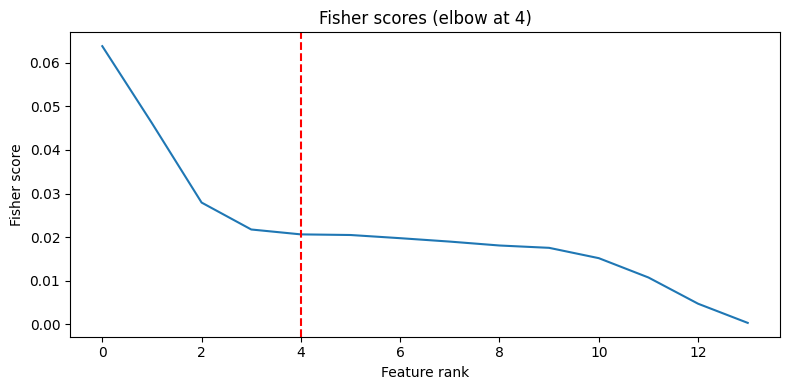

After _low_fisher_score: D = 9
After _corr_groups_by_mi: D = 5
Latent representation start: D = 5


In [44]:
class LatentRepresentationBuilding:
    """
    Build latent representations specifically for models.
    perform:
    - getting the 
    """
    def __init__(self, 
        X_train: np.ndarray, Y_train: np.ndarray, 
        X_val: np.ndarray, Y_val: np.ndarray,
        X_test: np.ndarray, Y_test: np.ndarray,
        verbose: bool = False
        ):
        self.X_train = X_train
        self.Y_train = Y_train
        self.X_validation = X_val
        self.Y_validation = Y_val
        self.X_test = X_test
        self.Y_test = Y_test
        
        self.verbose = verbose

        # learned from training data
        self.pca: PCA | None = None
    
    def _PCA(self, X:np.ndarray, train: bool = False, n_components = 0.99):
        """ make a PCA object on train data (when train=True), otherwise just use it """
        if train:
            self.pca = PCA(n_components=n_components) 
            self.pca.fit(X)
            
        if self.pca is None:
            raise RuntimeError("Call PCA first on training data")

        return self.pca.transform(X)

    def _make_latent(self, X: np.ndarray, Y:np.ndarray, latent_building:dict, train: bool = False) -> np.ndarray:
        if self.verbose and train:
            print(f"Latent representation start: D = {X.shape[1]}")

        for method_name, params in latent_building.items():
            # get method if it exists
            if not hasattr(self, method_name):
                print(f"Warning for latent building: no method {method_name} found > skipped.")
                continue

            fn = getattr(self, method_name)

            # decide whether the function needs Y
            if "Y" in fn.__code__.co_varnames:
                X = fn(X, Y, train, **params)
            else:
                X = fn(X, train, **params)

            if self.verbose and train:
                print(f"After {method_name}: D = {X.shape[1]}")

        return X

    def machine_learning_representation(self, used_features: dict, selection: dict, latent_building: dict):
        """ Build a representation for SVM, MLP, Random forest or Fuzzy system
        input:
        - used_features: dict ; instruct which parameters to get and the associated parameter values
        - selection_procedure: dict ; instruct how to select dimensions and the parameters for that selection
        - latent_building: dict ; instruct how to build a latent representation from the final parameters and the parameters for that
        """ 
        # get the features that are used
        feature_extractor = FeatureExtraction(used_features)
        X_train_features = feature_extractor.get_features(self.X_train, "data/features/train/", verbose=self.verbose)
        X_validation_features = feature_extractor.get_features(self.X_validation, "data/features/validation/")
        X_test_features = feature_extractor.get_features(self.X_test, "data/features/test/")

        # select the dimensions
        dimension_selector = DimensionSelection(selection)
        X_train_selected = dimension_selector.fit_and_select(X_train_features, self.Y_train, verbose=self.verbose)
        X_validation_selected = dimension_selector.select(X_validation_features)
        X_test_selected = dimension_selector.select(X_test_features)
                
        # build a latent representation from the right dimensions
        X_train_latent = self._make_latent(X_train_selected, self.Y_train, latent_building, train=True)
        X_validation_latent = self._make_latent(X_validation_selected, self.Y_validation, latent_building)
        X_test_latent = self._make_latent(X_test_selected, self.Y_test, latent_building)

        return X_train_latent, X_validation_latent, X_test_latent

shared_selected_features_params = {
    "HOG": {
        "cell_pixels": 8,
        "block": 2,
        "nbins": 9,
    },
    "LBP": {
        "P": 8,
        "R": 1.0,
        "method": "uniform",
        "n_bins": None,
    },
    "GLCM": {},  # no params in method signature
    "DCT": {
        "k": 8,
    },
    "wavelet_transform": {},  
    "hu_moments": {},         
    "zernike_moments": {
        "degree": 8,
        "use_magnitude": True,
    },  # takes quite long
}

# now according to description above ------- Experiment with these --------------------:
# support vector machine
SVM_used_features = {
    "HOG": shared_selected_features_params["HOG"],
    "LBP": shared_selected_features_params["LBP"],
    "DCT": shared_selected_features_params["DCT"],
}
SVM_selection = {
    "_low_variance": {"threshold": 1e-3},
    "_low_fisher_score": {"keep_minimum_d": 30},
    "_corr_groups_by_mi": {"corr_threshold": 0.90},
}
SVM_latent_building = {"_PCA": {"n_components": 20}} # if float between 0-1 it is how much variance to keep; if an integers it is how many components to keep

# Multi layer perceptron
MLP_used_features = {
    "HOG": shared_selected_features_params["HOG"],
    "LBP": shared_selected_features_params["LBP"],
    "DCT": shared_selected_features_params["DCT"],
    "wavelet_transform": shared_selected_features_params["wavelet_transform"],
    "hu_moments": shared_selected_features_params["hu_moments"],
    "zernike_moments": shared_selected_features_params["zernike_moments"]
}
MLP_selection = {
    "_low_variance": {"threshold": 1e-2},
    "_low_fisher_score": {"keep_minimum_d": 50},
    "_corr_groups_by_mi": {"corr_threshold": 0.90},
}
MLP_latent_building = {"_PCA": {"n_components": 0.99}}

# Random Forest
RF_used_features = {
    "LBP": shared_selected_features_params["LBP"],
    "wavelet_transform": shared_selected_features_params["wavelet_transform"],
    "hu_moments": shared_selected_features_params["hu_moments"],
}
RF_selection = {
    "_low_variance": {"threshold": 1e-2},
    "_low_fisher_score": {"keep_minimum_d": 40},
    "_corr_groups_by_mi": {"corr_threshold": 0.90},
}
RF_latent_building = {"_PCA": {"n_components": 0.99}}

# Fuzzy system
Fuzzy_used_features = {
    "wavelet_transform": shared_selected_features_params["wavelet_transform"],
    "hu_moments": shared_selected_features_params["hu_moments"],
}
Fuzzy_selection = {
    "_low_variance": {"threshold": 1e-2},
    "_low_fisher_score": {"keep_minimum_d": 9},
    "_corr_groups_by_mi": {"corr_threshold": 0.90},
}
Fuzzy_latent_building = {}

## ----------------------------------------------------------

latent_rep_builder = LatentRepresentationBuilding(X_train_augmented, Y_train_augmented, X_validation, Y_validation, X_test, Y_test, verbose=True)

X_train_SVM, X_validation_SVM, X_test_SVM = latent_rep_builder.machine_learning_representation(SVM_used_features, SVM_selection, SVM_latent_building)
X_train_MLP, X_validation_MLP, X_test_MLP = latent_rep_builder.machine_learning_representation(MLP_used_features, MLP_selection, MLP_latent_building)
X_train_RF, X_validation_RF, X_test_RF = latent_rep_builder.machine_learning_representation(RF_used_features, RF_selection, RF_latent_building)
X_train_Fuzzy, X_validation_Fuzzy, X_test_Fuzzy = latent_rep_builder.machine_learning_representation(Fuzzy_used_features, Fuzzy_selection, Fuzzy_latent_building)

### Applying machine learning models
Evaluation is done based on:
- accuracy:
- balanced accuracy:
- cohen's kappa:
- F1 score:
- Confusion matrix

In [ ]:
class PyFUMEClassifier(BaseEstimator, ClassifierMixin):
    """
    sklearn-like classifier that wraps pyFUME to fit in with the other
    """
    def __init__(self, nr_clus: int =7, merge_threshold: float =1.0):
        self.nr_clus = nr_clus
        self.merge_threshold = merge_threshold
        
        self._builder = None  # pyFUME object after fit
        # classify between 0 and 6 for these emotions
        self._y_min = 0
        self._y_max = 6
    
    def _clean(self, X: np.ndarray) -> np.ndarray:
        """ gave errrors without cleaning"""
        X = np.asarray(X, dtype=np.float64)  
        return np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

    def fit(self, X: np.ndarray, y: np.ndarray):
        # ensure the Simpful code executor has numpy - gave errors
        import pyfume.simpfulfier as _simpful_mod
        _simpful_mod.np = np
        
        X = self._clean(X)
        y = np.asarray(y).reshape(-1, 1)

        # Build column names: X0..X{D-1} + 'OUTPUT'
        D = X.shape[1]
        feat_cols = [f"X{i}" for i in range(D)]
        var_names = feat_cols + ["OUTPUT"]

        df = pd.DataFrame(X, columns=feat_cols)
        df["OUTPUT"] = y


        # Create and fit pyFUME model using dataframe API
        self._builder = pyFUME(
            dataframe=df,
            nr_clus=self.nr_clus,
            process_categorical=False, # all our intput dimensions are continuous
            method='Takagi-Sugeno', # best for regression like tasks
            variable_names=var_names,
            merge_threshold=self.merge_threshold,
            model_order="zero",         # <— key: use zero-order model
            categorical_indices=[],     # <— make this explicit (avoid typing alias)
        )
        # pyFUME learns the model at construction time using the dataframe
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        if self._builder is None:
            raise RuntimeError("Call fit before predict")
        X = self._clean(X)
        y_cont = self._builder.predict_label(X)      # continuous predictions
        y_pred = np.rint(y_cont).astype(int)         # nearest class id
        y_pred = np.clip(y_pred, self._y_min, self._y_max)
        return y_pred.ravel()

class MachineLearning:
    """
    Steps:
    1. Do a gridsearch hyperparameter optimiation to get a model, based on train X and Y. 
    2. Evaluate the performance of the model on training and validation data
        - possibly propose a new set of hyperparameters to search over
    3. Show the performance on test data and use that to compare models   
    
    """
    def __init__(self, Y_train: np.ndarray, Y_validation:np.ndarray, Y_test: np.ndarray, hyper_opt_metric: str = "balanced_accuracy", n_K_split: int = 5, save_dir: str = "models/", verbose: bool = False):
        self.Y_train = Y_train
        self.Y_validation = Y_validation
        self.Y_test = Y_test

        self.hyper_op_metric = hyper_opt_metric
        self.n_K_split = n_K_split

        self.verbose = verbose
        self.random_state = 1712411
        self.save_dir = save_dir

        self.models = {
            "SVM": SVC(),
            "MLP": MLPClassifier(max_iter=200, early_stopping=True, n_iter_no_change=10, random_state=self.random_state),
            "RF": RandomForestClassifier(random_state=self.random_state),
            "fuzzy": PyFUMEClassifier()
        }

    def hyperparam_optimized_model(self, X_train:np.ndarray, model_fn: callable, param_grid: dict): # what is the datatype of what is returned?
        """ gives the best model from the param search grid """
        cv = StratifiedKFold(self.n_K_split, shuffle=True, random_state=self.random_state) # divide data up into K sections
        grid_search = GridSearchCV(model_fn, param_grid=param_grid, scoring=self.hyper_op_metric, cv=cv, n_jobs = -1, verbose=self.verbose, error_score="raise")
        grid_search.fit(X_train, self.Y_train)
        if self.verbose:
            print(f"[GridSearch] Best params: {grid_search.best_params_}")
        return grid_search.best_estimator_, grid_search.best_params_
    
    def evaluate_performance(self, Y_true, Y_pred):
        print("Accuracy:", accuracy_score(Y_true, Y_pred))
        print("Balanced accuracy:", balanced_accuracy_score(Y_true, Y_pred))
        print(f"Cohen's Kappa:", cohen_kappa_score(Y_true, Y_pred))
        print("F1 (macro):", f1_score(Y_true, Y_pred, average="macro"))
        print("Confusion matrix:\n", confusion_matrix(Y_true, Y_pred))
        print("\nClassification report:\n", classification_report(Y_true, Y_pred))
    
    def save_trained_model(self, model_name, ML_model, ML_best_params):
        os.makedirs(self.save_dir, exist_ok=True)
        param_str = "_".join([f"{k}_{v}" for k, v in ML_best_params.items()])
        filename = f"{model_name}_{param_str}.pkl"
        filepath = os.path.join(self.save_dir, filename)

        dump(ML_model, filepath)
        if self.verbose:
            print(f"[Saved model] {filepath}")
        
    def get_ML_model(self, model_name:str, X_train:np.ndarray, X_val:np.ndarray, X_test:np.ndarray, param_grid:dict, check_test: bool=False):
        """ The entire pipeline for evaluating a model"""
        if model_name not in self.models:
            raise ValueError(f"model unknown choose from: {self.models.items()}")
    
        model_fn = self.models[model_name]

        ML_model, ML_best_params = self.hyperparam_optimized_model(X_train, model_fn, param_grid)

        # save a model as pkl file using <name_param1_val1_...param1_val_i
        self.save_trained_model(model_name, ML_model, ML_best_params)
        
        # check training data
        Y_pred_train = ML_model.predict(X_train)
        print("---- Training data ----")
        self.evaluate_performance(self.Y_train, Y_pred_train)

        # check validation data
        Y_pred_val = ML_model.predict(X_val)
        print("---- Validation data ----")
        self.evaluate_performance(self.Y_validation, Y_pred_val)

        if check_test:
            Y_pred_test = ML_model.predict(X_test)
            print("---- Test data ----")
            self.evaluate_performance(self.Y_test, Y_pred_test)

        return ML_model, ML_best_params
    
    def evaluate_saved_ML_model(self, model_load_name: str, X_train:np.ndarray, X_val:np.ndarray, X_test:np.ndarray):

        ML_model = load(f"models/{model_load_name}.pkl")

        # check training data
        Y_pred_train = ML_model.predict(X_train)
        print("---- Training data ----")
        self.evaluate_performance(self.Y_train, Y_pred_train)

        # check validation data
        Y_pred_val = ML_model.predict(X_val)
        print("---- Validation data ----")
        self.evaluate_performance(self.Y_validation, Y_pred_val)

        Y_pred_test = ML_model.predict(X_test)
        print("---- Test data ----")
        self.evaluate_performance(self.Y_test, Y_pred_test)

## ----- Experiment with these -------:
SVM_param_grid = {
    "C": [1],#, 3, 10],
    "gamma": ["scale"],#, 0.01, 0.03],
    "kernel": ["rbf"] # other option is 'linear'
}

MLP_param_grid = {
    "hidden_layer_sizes": [(256, 128)],#, (256,), (256, 128)],
    "activation": ["relu"],# "tanh"],
    "alpha": [1e-2],# 1e-3, 1e-2], # L2 regularization
    "learning_rate_init": [1e-3],# 3e-4], 
}

RF_param_grid = {
    "n_estimators": [500],# 500],
    "max_depth": [20],# 20, 40],
    "max_features": ["log2"],# "log2", 0.5],
    "min_samples_leaf": [2],# 2, 5],
    "class_weight": ["balanced"],# "balanced"]
}

fuzzy_param_grid = {
    "nr_clus": [13],#10,13],
    "merge_threshold": [0.95],# 0.9, 0.95, 1.0] # between 0 and 1
}
## -------------------------------------

emotion_recognize_model_builder = MachineLearning(Y_train_augmented, Y_validation, Y_test, n_K_split=2,  verbose = True)

SVM_model, SVM_params = emotion_recognize_model_builder.get_ML_model("SVM", X_train_SVM, X_validation_SVM, X_test_SVM, SVM_param_grid, check_test=True)

MLP_model, MLP_params = emotion_recognize_model_builder.get_ML_model("MLP", X_train_MLP, X_validation_MLP, X_test_MLP, MLP_param_grid, check_test=True)

RF_model, RF_params = emotion_recognize_model_builder.get_ML_model("RF", X_train_RF, X_validation_RF, X_test_RF, RF_param_grid, check_test=True)
    
Fuzzy_model, Fuzzy_params = emotion_recognize_model_builder.get_ML_model("fuzzy", X_train_Fuzzy, X_validation_Fuzzy, X_test_Fuzzy, fuzzy_param_grid, check_test=True)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[GridSearch] Best params: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
[Saved model] models/SVM_C_1_gamma_scale_kernel_rbf.pkl
---- Training data ----
Accuracy: 0.4754711751662971
Balanced accuracy: 0.47547117516629717
Cohen's Kappa: 0.38804970436067987
F1 (macro): 0.4596297293194879
Confusion matrix:
 [[2187 1189  443  895  844  674  984]
 [ 340 5380  182  234  291  457  332]
 [ 675 1219 1782  781  688 1111  960]
 [ 365  218  196 5058  533  245  601]
 [ 703  879  436 1088 2503  486 1121]
 [ 397  962  395  510  323 3918  711]
 [ 593  751  322  998  755  608 3189]]

Classification report:
               precision    recall  f1-score   support

           0       0.42      0.30      0.35      7216
           1       0.51      0.75      0.60      7216
           2       0.47      0.25      0.32      7216
           3       0.53      0.70      0.60      7216
           4       0.42      0.35      0.38      7216
           5       0.

In [ ]:
model_name = "MLP_activation_relu_alpha_0.0001_hidden_layer_sizes_(512,)_learning_rate_init_0.001"
emotion_recognize_model_builder.evaluate_saved_ML_model(model_name, X_train_MLP, X_validation_MLP, X_test_MLP)